1. Over here we will be predicting the Adjusted closing price of Tesla's stock over 1-day, 5-day and 10-day horizon using LSTM (Long Short-Term Memory) model.

2. Defining a function to build an LSTM model.

In [2]:
# Importing the libraries and functions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import os
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from utils.timeseries_utils import plot_test_pred, create_sequences, inverse_transform_adj_close

In [3]:
# Helper to build the model
def build_lstm(input_shape, dropout_rate=0.2, learning_rate=0.001, units=50):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))                 # LSTM layer
    model.add(Dropout(dropout_rate))                                # Dropout layer -> drops a certain fraction of inputs, reduces overfitting
    model.add(Dense(1))                                             # Output layer with one neuron, good for continuous output and regression tasks
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse', metrics=['mae'])
    return model

3. Defining reusable callbacks to control and monitor the training process.

In [4]:
def get_callbacks(model_name):
    os.makedirs('models', exist_ok=True)                    # Ensure that the directory exists
    early_stopping = EarlyStopping(                         # EarlyStopping stops training once convergence is reached, prevents overfitting 
        monitor='val_loss',                                 # Watches validation loss
        patience=5,                                         # Wait for 5 epochs with no improvement  
        restore_best_weights=True)                          # Use best weights   
    
    checkpoint = ModelCheckpoint(                           # Saves model during training
        filepath=f"../data/models/lstm/{model_name}.h5",    # Path where the file of the model will be saved   
        monitor='val_loss',                                 # Save when val_loss is best
        save_best_only=True)                                # Only save better models, not worse ones
    return [early_stopping, checkpoint]

3. Loading the saved files and scaler.

In [5]:
# Loading the scalar
scaler = joblib.load('../data/artifacts/scaler.joblib')

# Loading the scaled training data
train_scaled = joblib.load('../data/artifacts/train_scaled.joblib')

# Loading the scaled validation data
val_scaled = joblib.load('../data/artifacts/val_scaled.joblib')

# Loading the scaled test data
test_scaled = joblib.load('../data/artifacts/test_scaled.jolib')

# Checking the shape of these datas
print(train_scaled.shape, val_scaled.shape, test_scaled.shape)

(1691, 2) (362, 2) (363, 2)


4. Creating the input-output sequences using the helper, create_sequences.

In [6]:
# Setting the lookback period
lookback = 60

In [7]:
# For 1-day horizon
x_train_1s, y_train_1s = create_sequences(train_scaled, lookback, horizon=1)
x_val_1s, y_val_1s = create_sequences(val_scaled, lookback, horizon=1)
x_test_1s, y_test_1s = create_sequences(test_scaled, lookback, horizon=1)

# Checking the shape of the datasets
print('Training:\n',x_train_1s.shape, y_train_1s.shape)
print('Validation:\n',x_val_1s.shape, y_val_1s.shape)
print('Testing:\n',x_test_1s.shape, y_test_1s.shape)

Training:
 (1631, 60, 2) (1631,)
Validation:
 (302, 60, 2) (302,)
Testing:
 (303, 60, 2) (303,)


In [8]:
# For 5-day horizon
x_train_5s, y_train_5s = create_sequences(train_scaled, lookback, horizon=5)
x_val_5s, y_val_5s = create_sequences(val_scaled, lookback, horizon=5)
x_test_5s, y_test_5s = create_sequences(test_scaled, lookback, horizon=5)

# Checking the shape of the datasets
print('Training:\n',x_train_5s[0].shape, y_train_5s.shape)
print('Validation:\n',x_val_5s[0].shape, y_val_5s.shape)
print('Testing:\n',x_test_5s[0].shape, y_test_5s.shape)

Training:
 (60, 2) (1627,)
Validation:
 (60, 2) (298,)
Testing:
 (60, 2) (299,)


In [9]:
# For 10-day horizon
x_train_10s, y_train_10s = create_sequences(train_scaled, lookback, horizon=10)
x_val_10s, y_val_10s = create_sequences(val_scaled, lookback, horizon=10)
x_test_10s, y_test_10s = create_sequences(test_scaled, lookback, horizon=10)

# Checking the shape of the datasets
print('Training:\n',x_train_10s[0].shape, y_train_10s.shape)
print('Validation:\n',x_val_10s[0].shape, y_val_10s.shape)
print('Testing:\n',x_test_10s[0].shape, y_test_10s.shape)

Training:
 (60, 2) (1622,)
Validation:
 (60, 2) (293,)
Testing:
 (60, 2) (294,)


5. Training the model using the previously built function and evaluating it for 1-day horizon.

In [10]:
# Building the model
input_shape_1 = (x_train_1s.shape[1], x_train_1s.shape[2])
lstm_1day = build_lstm(input_shape_1)

# Training the model
history_1day = lstm_1day.fit(x_train_1s, y_train_1s,
                              epochs=50, batch_size=32,
                              validation_data=(x_val_1s, y_val_1s),
                              verbose=1, callbacks=get_callbacks('lstm_1day'))

# Evaluation
test_loss_1day, test_mae_1day = lstm_1day.evaluate(x_test_1s, y_test_1s)                        
print('\nTest MSE for 1-day:', test_loss_1day)
print('Test MAE for 1-day:', test_mae_1day)

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 0.0429 - mae: 0.1364

c:\Users\maa\Desktop\PYTHON\My_Projects\Tesla_Stock_Price_Prediction\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 14s 111ms/step - loss: 0.0429 - mae: 0.1364 - val_loss: 0.0061 - val_mae: 0.0628
Epoch 2/50
51/51 [==============================] - 4s 69ms/step - loss: 0.0051 - mae: 0.0492 - val_loss: 0.0050 - val_mae: 0.0534
Epoch 3/50
51/51 [==============================] - 3s 64ms/step - loss: 0.0046 - mae: 0.0450 - val_loss: 0.0046 - val_mae: 0.0509
Epoch 4/50
51/51 [==============================] - 4s 70ms/step - loss: 0.0039 - mae: 0.0416 - val_loss: 0.0039 - val_mae: 0.0473
Epoch 5/50
51/51 [==============================] - 3s 67ms/step - loss: 0.0034 - mae: 0.0396 - val_loss: 0.0037 - val_mae: 0.0467
Epoch 6/50
51/51 [==============================] - 4s 70ms/step - loss: 0.0033 - mae: 0.0386 - val_loss: 0.0046 - val_mae: 0.0513
Epoch 7/50
51/51 [==============================] - 4s 70ms/step - loss: 0.0029 - mae: 0.0362 - val_loss: 0.0047 - val_mae: 0.0542
Epoch 8/50
51/51 [==============================] - 3s 64ms/step - loss: 0.0028 - mae: 0.035

In [11]:
# Generating predictions on test set for 1-day
y_pred_1_scaled = lstm_1day.predict(x_test_1s)

10/10 [==============================] - 1s 31ms/step


In [12]:
# Inverse tranform predictions for 1-day
y_pred_1 = inverse_transform_adj_close(y_pred_1_scaled, scaler)

# Inverse transform actual test values
y_test_1 = inverse_transform_adj_close(y_test_1s, scaler)

# Checking the values after inverse transform
print(y_pred_1[:5])
print(y_test_1[:5])

[346.88418972 348.03533259 349.71390139 349.70752279 347.31687099]
[354.309998 353.470001 347.48999  338.190002 325.829987]


---------- For 1-day horizon ----------


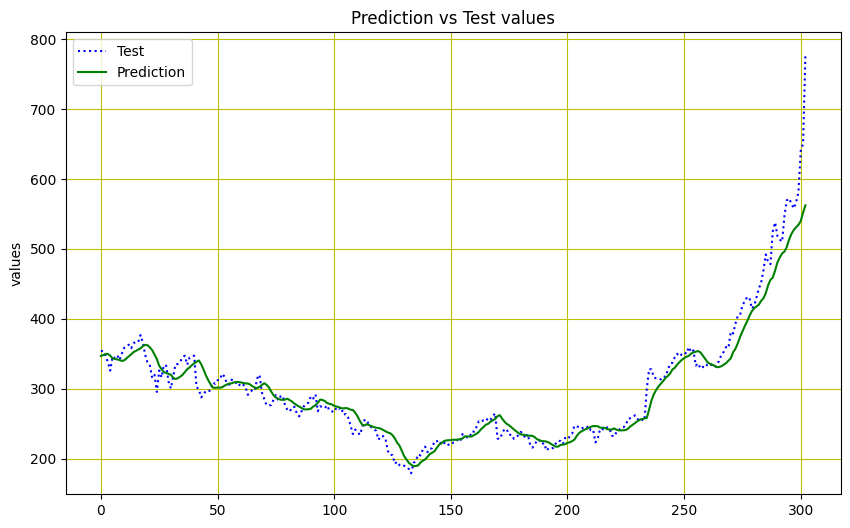

In [13]:
# Plotting the graph between actual test values and predictions using the function, plot_test_pred
print('---------- For 1-day horizon ----------')
fig = plot_test_pred(y_pred_1, y_test_1)
plt.show()

Insights-

From the graph above, we see that for 1-day forecast, the LSTM model successfully captures the overall trend of the stock price. The predicted values closely follow the actual prices with a smoother trajectory.

6. Training the model using the previously built function and evaluating it for 5-day horizon.

In [14]:
# Building the model
input_shape_5 = (x_train_5s.shape[1], x_train_5s.shape[2])
lstm_5day = build_lstm(input_shape_5)

# Training the model
history_5day = lstm_5day.fit(x_train_5s, y_train_5s,
                             epochs=50, batch_size=32,
                             validation_data=(x_val_5s, y_val_5s),
                             callbacks=get_callbacks('lstm_5day'), verbose=1)

# Evaluation
test_loss_5day, test_mae_5day = lstm_5day.evaluate(x_test_5s, y_test_5s)
print('\nTest MSE for 5-day:', test_loss_5day)
print('Test MAE for 5-day:', test_mae_5day)

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.1194

c:\Users\maa\Desktop\PYTHON\My_Projects\Tesla_Stock_Price_Prediction\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 10s 95ms/step - loss: 0.0320 - mae: 0.1194 - val_loss: 0.0110 - val_mae: 0.0838
Epoch 2/50
51/51 [==============================] - 3s 58ms/step - loss: 0.0056 - mae: 0.0511 - val_loss: 0.0071 - val_mae: 0.0652
Epoch 3/50
51/51 [==============================] - 3s 62ms/step - loss: 0.0048 - mae: 0.0468 - val_loss: 0.0068 - val_mae: 0.0636
Epoch 4/50
51/51 [==============================] - 3s 60ms/step - loss: 0.0045 - mae: 0.0452 - val_loss: 0.0082 - val_mae: 0.0705
Epoch 5/50
51/51 [==============================] - 3s 59ms/step - loss: 0.0047 - mae: 0.0466 - val_loss: 0.0139 - val_mae: 0.0967
Epoch 6/50
51/51 [==============================] - 3s 58ms/step - loss: 0.0045 - mae: 0.0450 - val_loss: 0.0111 - val_mae: 0.0845
Epoch 7/50
51/51 [==============================] - 3s 59ms/step - loss: 0.0041 - mae: 0.0430 - val_loss: 0.0081 - val_mae: 0.0702
Epoch 8/50
10/10 [==============================] - 0s 26ms/step - loss: 0.0200 - mae: 0.0952

In [15]:
# Generating predictions on test set for 5-day
y_pred_5_scaled = lstm_5day.predict(x_test_5s)

10/10 [==============================] - 1s 29ms/step


In [16]:
# Inverse tranform predictions for 5-days
y_pred_5 = inverse_transform_adj_close(y_pred_5_scaled, scaler)

# Inverse transform actual test values
y_test_5 = inverse_transform_adj_close(y_test_5s, scaler)

# Checking the values after inverse transform
print(y_pred_5[:5])
print(y_test_5[:5])

[338.36167986 340.65819909 343.48726645 344.66418141 343.53388173]
[325.829987 346.       343.920013 347.869995 341.170013]


--------- For 5-day horizon ---------


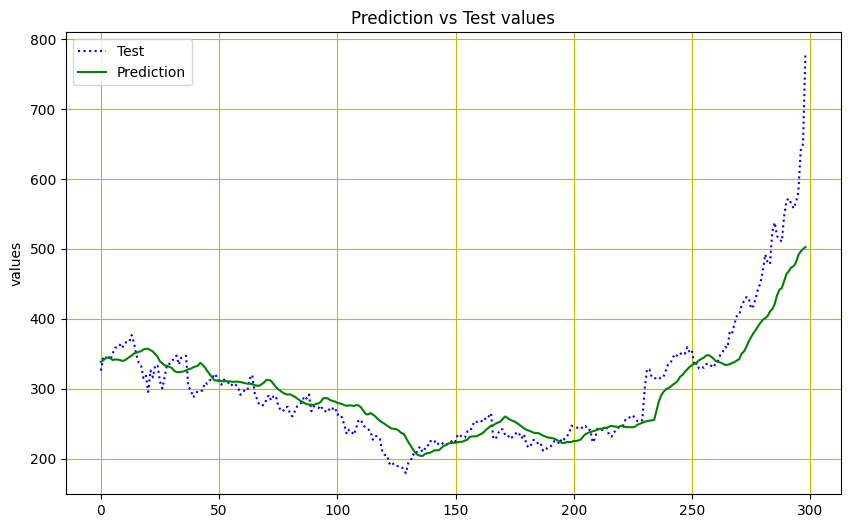

In [17]:
# Plotting the graph between actual test values and predictions using the function, plot_test_pred
print('--------- For 5-day horizon ---------')
plot_test_pred(y_pred_5, y_test_5)
plt.show()

Insights-

From the above graph, we see that the LSTM model successfully captures the trend of the prices and the predictions are smoother than the actual prices. A noticeable lag exists between the predicted prices and actual values.

7. Training the model using the previously built function and evaluating it for 10-day horizon.

In [18]:
# Building the model
input_shape_10 = (x_train_10s.shape[1], x_train_10s.shape[2])
lstm_10day = build_lstm(input_shape_10)

# Training the model
history_10day = lstm_10day.fit(x_train_10s, y_train_10s,
                             epochs=50, batch_size=32,
                             validation_data=(x_val_10s, y_val_10s),
                             callbacks=get_callbacks('lstm_10day'), verbose=1)

# Evaluation
test_loss_10day, test_mae_10day = lstm_10day.evaluate(x_test_10s, y_test_10s)
print('\nTest MSE for 10-day:', test_loss_10day)
print('Test MAE for 10-day:', test_mae_10day)

Epoch 1/50
51/51 [==============================] - 11s 89ms/step - loss: 0.0776 - mae: 0.1883 - val_loss: 0.0128 - val_mae: 0.0892
Epoch 2/50
 1/51 [..............................] - ETA: 4s - loss: 0.0085 - mae: 0.0813

c:\Users\maa\Desktop\PYTHON\My_Projects\Tesla_Stock_Price_Prediction\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 3s 61ms/step - loss: 0.0085 - mae: 0.0676 - val_loss: 0.0097 - val_mae: 0.0758
Epoch 3/50
51/51 [==============================] - 3s 59ms/step - loss: 0.0067 - mae: 0.0557 - val_loss: 0.0110 - val_mae: 0.0811
Epoch 4/50
51/51 [==============================] - 3s 59ms/step - loss: 0.0064 - mae: 0.0549 - val_loss: 0.0096 - val_mae: 0.0750
Epoch 5/50
51/51 [==============================] - 3s 59ms/step - loss: 0.0064 - mae: 0.0537 - val_loss: 0.0096 - val_mae: 0.0748
Epoch 6/50
51/51 [==============================] - 3s 57ms/step - loss: 0.0056 - mae: 0.0517 - val_loss: 0.0147 - val_mae: 0.0971
Epoch 7/50
51/51 [==============================] - 3s 59ms/step - loss: 0.0059 - mae: 0.0516 - val_loss: 0.0102 - val_mae: 0.0780
Epoch 8/50
51/51 [==============================] - 3s 58ms/step - loss: 0.0059 - mae: 0.0524 - val_loss: 0.0099 - val_mae: 0.0767
Epoch 9/50
10/10 [==============================] - 0s 23ms/step - loss: 0.0328 - mae: 0.1211


In [19]:
# Generating predictions on test set for 10-days
y_pred_10_scaled = lstm_10day.predict(x_test_10s)

10/10 [==============================] - 1s 27ms/step


In [20]:
# Inverse tranform predictions for 10-days
y_pred_10 = inverse_transform_adj_close(y_pred_10_scaled, scaler)

# Inverse transform actual test values
y_test_10 = inverse_transform_adj_close(y_test_10s, scaler)

# Checking the values after inverse transform
print(y_test_10[:5])
print(y_pred_10[:5])

[350.480011 358.48999  359.700012 363.059998 357.970001]
[342.15175646 342.84322178 344.33787446 345.52213447 345.44323964]


------------- For 10-day horizon -------------

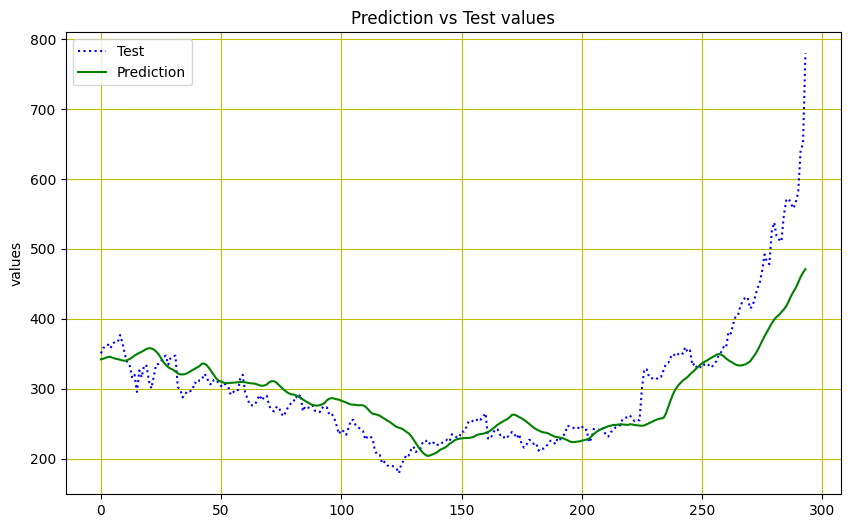

In [21]:
# Plotting the graph between actual test values and predictions using the function, plot_test_pred
print('------------- For 10-day horizon -------------')
plot_test_pred(y_pred_10, y_test_10)
plt.show()

Insights-

From the above graph for 10-day forecast, we see that the predictions are significantly smoother as compared to the actual prices, which shows that the model ignores short-term volatility.

8. Comparision between the two models- SimpleRNN vs. LSTM-

In [ ]:
# 1-Day test scores:

# Model:    SimpleRNN   LSTM
# MSE:      0.0139      0.0078
# MAE:      0.0716      0.0557


# 5-Day test scores:

# Model:    SimpleRNN   LSTM
# MSE:      0.0480      0.0200
# MAE:      0.1362      0.0952


# 10-Day test scores:

# Model:    SimpleRNN   LSTM
# MSE:      0.0385      0.0328
# MAE:      0.1239      0.1210

So, from the above table we see that LSTM performs the best for all 3 horizons.